In [34]:
import cudf
import numpy as np
import sys
import os
import argparse
import pickle
import fnmatch
from tqdm import tqdm
import re
import itertools
import random
import argparse
import matplotlib.pyplot as plt
import pandas as pd 
import matplotlib.cm as cm
from sklearn import manifold

ROOTDIR = '/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/'
RESULTDIR = '/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/results'
analyze_dir = '/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/analyze/'

# model_identifier = 'linear_NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.0923671_sigma=5.0_nfeat=936-train_test-fixed'
# model_identifier = 'linear_NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.0923671_sigma=5.0_nfeat=936-train_test-fixed'
model_identifier = 'NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed'
train_identifier = 'epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06'
analyze_identifier = 'mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5'

## Helper functions ##
def moving_average(x,w):
    w_min=1#int(np.floor(w/2))
    return pd.Series(x).rolling(w, min_periods=w_min).mean()

av_window=10

In [35]:
with open(os.path.join(analyze_dir, f"d_fig2_plot_specs_{model_identifier}.pkl"), "rb") as input_file:
    d = pickle.load(input_file)


___________ Layer: layer_1_Linear____________
Hierarchy 0: Fixed point collapsed: 319 | Fixed point: 31721


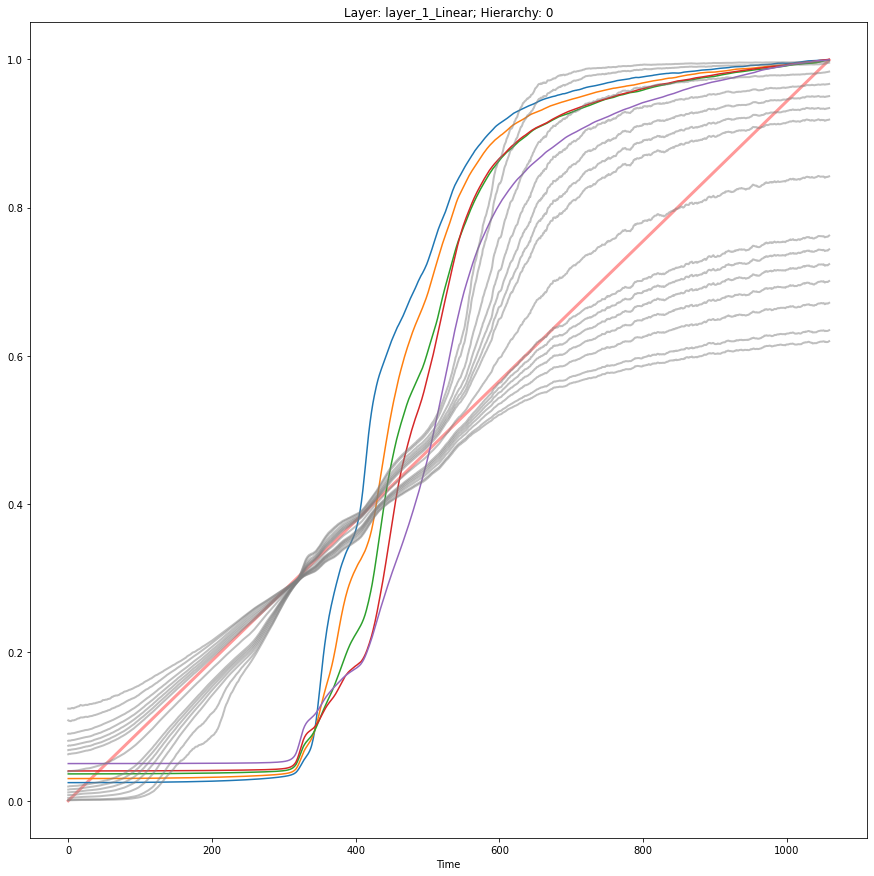

In [38]:
## INCLUDE PLOTS IN THE LOOP ##
## SPECS ALL ##
# layers = ['layer_1_Linear', 'layer_2_Linear', 'layer_3_Linear'] # 'layer_0_Input'
layers = ['layer_1_Linear']
hier_idxs = np.arange(6)
hier_idxs = [0]
num_colors=len(layers)+1
h0=cm.get_cmap('inferno_r',num_colors)
layer_cols=np.flipud(h0(np.arange(num_colors)/num_colors))
v='v3'

num_colors=len(hier_idxs)+1
h0=cm.get_cmap('viridis_r',num_colors)
hier_cols=np.flipud(h0(np.arange(num_colors)/num_colors))

for row, layer in enumerate(layers):
    print(f'\n___________ Layer: {layer}____________')
    for hier_idx in hier_idxs:

        num_subsamples = 100
        k = 100
        # hier_idx = 5
        # layer = layers[0]
        mov_avg = 10 
        save_fig = True
        collapse_subsamples = True # whether to average across num_subsamples! currently both computed
        p_array = [1, 5, 10, 15, 20, 25, 50, 75, 80, 85, 90, 95, 99]
        p_array = [0.01,0.1,0.5,1, 5, 10, 15, 20, 25, 50, 75, 80, 85, 90, 95, 99,99.5,99.9,99.99]
        p_array = [0.1,1, 5, 10, 15, 20, 25, 50, 75, 80, 85, 90, 95, 99,99.9]


        knn_identifier = f'knn_k={k}_subsamples={num_subsamples}'
        pkl_name = f'layer={layer}_hier={hier_idx}_{v}.pkl'

        SAVEDIR = os.path.join(ROOTDIR, 'analyze', knn_identifier, model_identifier, train_identifier)
        PLOTDIR = os.path.join(ROOTDIR, 'results', knn_identifier, model_identifier, train_identifier)

        if not os.path.exists(PLOTDIR):
            os.makedirs(PLOTDIR)

        data = pickle.load(open(os.path.join(SAVEDIR+'/'+pkl_name),'rb'))

        D = data['D']
        I = data['I']
        I_stand = I/np.max(I)
        epochs = data['epochs']  

        D_k_mean = np.mean(D,axis=1)
        D_k_mean_collapsed = np.mean(D_k_mean.reshape(-1, num_subsamples),axis=1)

        # analyses of fixed points and percentiles
        # compute percentiles
        p = np.percentile(I_stand, p_array, axis=1)
        p_collapse = [np.mean(x.reshape(-1, num_subsamples),axis=1) for x in p]
        time_diag = np.arange(len(D_k_mean))
        time_diag_collapsed = np.arange(len(D_k_mean_collapsed))/1060#*100

        norms = np.zeros((k-1, I.shape[0]))
        for i in range(1, k):
            norms[i-1, :] = I[:, 0] - I[:, i] 

        mean_norms = np.mean(norms,axis=0)
        mean_k_norms = np.mean(norms,axis=1)
        # norms_mov_avg = (moving_average(abs(mean_norms), mov_avg))

        norms_collapsed = np.mean(mean_norms.reshape(-1, num_subsamples),axis=1)

        # norms_mov_avg = moving_average(abs(mean_norms), mov_avg)
        norms_mov_avg = moving_average(abs(mean_norms), mov_avg)
        norms_mov_avg_collapsed = moving_average(abs(norms_collapsed), mov_avg)
        fixed_point = np.argmin((norms_mov_avg))
        fixed_point_collapsed = np.argmin((norms_mov_avg_collapsed))
        print(f'Hierarchy {hier_idx}: Fixed point collapsed: {fixed_point_collapsed} | Fixed point: {fixed_point}')

        ## PLOTS ##
        alpha=0.5
        plt.figure(figsize=(15,15))
        for i in range(len(p_array)):
            plt.plot(np.arange(1060),moving_average(p_collapse[i], av_window), label=f'Percentile {p_array[i]}', alpha=alpha, color='grey',linewidth=2,zorder=5)
#         for h in range(6):
#             plt.plot(np.arange(1060),moving_average([accs[i][h] for i in range(len(accs))],av_window)/100,label=f'hier: {h}')
        
        k=1 # layer 1
        layer_data=d['dist'][k]
        for h, hier_data in enumerate(layer_data):
            distance_data=hier_data['data'].mean(axis=1)
            corrected_data=list(np.empty(1060)*np.NaN)
            for idx, x in enumerate(d['arr_']):
                corrected_data[int(x)]=distance_data[idx]

            plt.plot(moving_average(corrected_data/np.max(corrected_data),av_window),label=f"n_class:{hier_data['data'].shape[1]}")
        
        plt.xlabel('Time')
        plt.title(f'Layer: {layer}; Hierarchy: {hier_idx}')
        plt.plot(np.arange(len(p_collapse[0])), time_diag_collapsed,color=(1,.5,.5), label='Current pseudotime',linewidth=3,zorder=0,alpha=.8)

if not os.path.exists(f'{RESULTDIR}/{train_identifier}'):
    os.makedirs(f'{RESULTDIR}/{train_identifier}')

# fig.savefig(f'{RESULTDIR}/{train_identifier}/fig0_{model_identifier}_{v}.pdf')
# fig1.savefig(f'{RESULTDIR}/{train_identifier}/fig1_{model_identifier}_{v}.pdf')
# fig2.savefig(f'{RESULTDIR}/{train_identifier}/fig2_{model_identifier}_{v}.pdf')

In [69]:
len(p_collapse[0])

1060

In [76]:
p.shape

(3, 106000)

In [79]:
p_collapse[0].shape

(1060,)

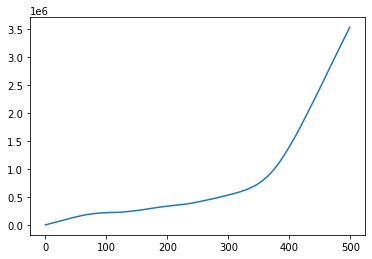

In [91]:
plt.plot(np.cumsum(p_collapse[2][200:700] - p_collapse[1][200:700]))

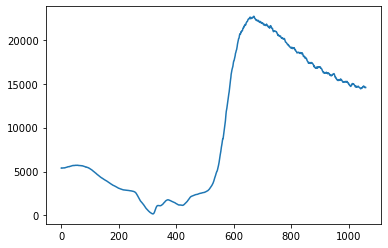

In [96]:
plt.plot(moving_average(p_collapse[2], av_window) - moving_average(p_collapse[1], av_window))

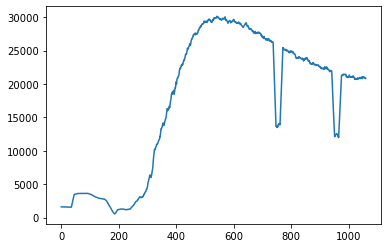

In [100]:
plt.plot(moving_average(p_collapse[2], av_window) - moving_average(p_collapse[1], av_window))

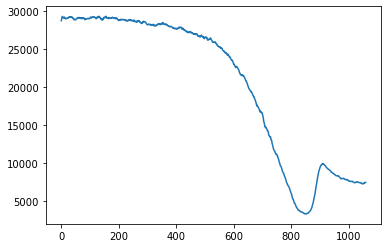

In [103]:
plt.plot(moving_average(p_collapse[2], av_window) - moving_average(p_collapse[1], av_window)) # partition line

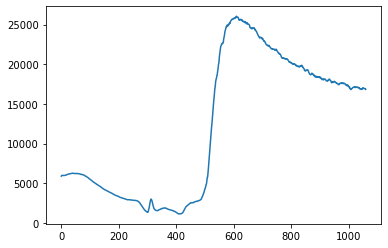

In [108]:
plt.plot(moving_average(p_collapse[2], av_window) - moving_average(p_collapse[1], av_window)) # partition line

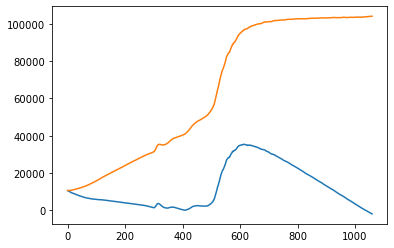

In [119]:
plt.plot(moving_average(p_collapse[2], av_window) - time_diag_collapsed) 
plt.plot(moving_average(p_collapse[2], av_window))

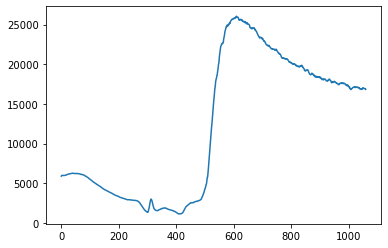

In [113]:
plt.plot(moving_average(p_collapse[2], av_window) - moving_average(p_collapse[1], av_window))

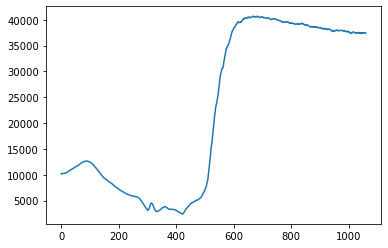

In [116]:
plt.plot(moving_average(p_collapse[2], av_window) - moving_average(p_collapse[0], av_window))

In [ ]:
## SPECS ALL ##
#layers = ['layer_1_Linear', 'laxyer_2_Linear', 'layer_3_Linear'] # 'layer_0_Input'
layers = ['layer_3_Linear']
hier_idxs = np.arange(6)
v = 'v3'
n_components = 2

for layer in layers:
    print(f'\n___________ Layer: {layer}____________')
    method = manifold.MDS(n_components, max_iter=100, n_init=1)
    for hier_idx in hier_idxs:
        if hier_idx == 3:
            break
        num_subsamples = 100
        k = 100
        # hier_idx = 5
        # layer = layers[0]
        mov_avg = 10 
        save_fig = True
        collapse_subsamples = True # whether to average across num_subsamples! currently both computed
        p_array = [5, 50, 95]

        knn_identifier = f'knn_k={k}_subsamples={num_subsamples}'
        pkl_name = f'layer={layer}_hier={hier_idx}_with_data.pkl'

        SAVEDIR = os.path.join(ROOTDIR, 'analyze', knn_identifier, model_identifier, train_identifier)
        PLOTDIR = os.path.join(ROOTDIR, 'results', knn_identifier, model_identifier, train_identifier)

        if not os.path.exists(PLOTDIR):
            os.makedirs(PLOTDIR)

        data = pickle.load(open(os.path.join(SAVEDIR+'/'+pkl_name),'rb'))

        D = data['D']
        I = data['I']
        I_stand = I/np.max(I)
        I_collap = np.mean(I_stand.reshape(-1, num_subsamples, k),axis=1) # collapse across subsamples
        epochs = data['epochs']
        
#         for i in np.arange(100,1060, 100):
#             print(i)
#             plt.figure()
#             Y = method.fit_transform(I_collap[i:i+100])
#             plt.plot(Y)

        D_k_mean = np.mean(D,axis=1)
        D_k_mean_collapsed = np.mean(D_k_mean.reshape(-1, num_subsamples),axis=1)

        # analyses of fixed points and percentiles
        # compute percentiles
        p = np.percentile(I, p_array, axis=1)
        p_collapse = [np.mean(x.reshape(-1, num_subsamples),axis=1) for x in p]
        time_diag = np.arange(len(D_k_mean))
        time_diag_collapsed = np.arange(len(D_k_mean_collapsed))*100

        norms = np.zeros((k-1, I.shape[0]))
        for i in range(1, k):
            norms[i-1, :] = I[:, 0] - I[:, i] 

        mean_norms = np.mean(norms,axis=0)
        mean_k_norms = np.mean(norms,axis=1)
        # norms_mov_avg = (moving_average(abs(mean_norms), mov_avg))

        norms_collapsed = np.mean(mean_norms.reshape(-1, num_subsamples),axis=1)

        # norms_mov_avg = moving_average(abs(mean_norms), mov_avg)
        norms_mov_avg = moving_average(abs(mean_norms), mov_avg)
        norms_mov_avg_collapsed = moving_average(abs(norms_collapsed), mov_avg)
        fixed_point = np.argmin((norms_mov_avg))
        fixed_point_collapsed = np.argmin((norms_mov_avg_collapsed))
        print(f'Hierarchy {hier_idx}: Fixed point collapsed: {fixed_point_collapsed} | Fixed point: {fixed_point}')

Fixed point collapsed, hierarchy 2: 337


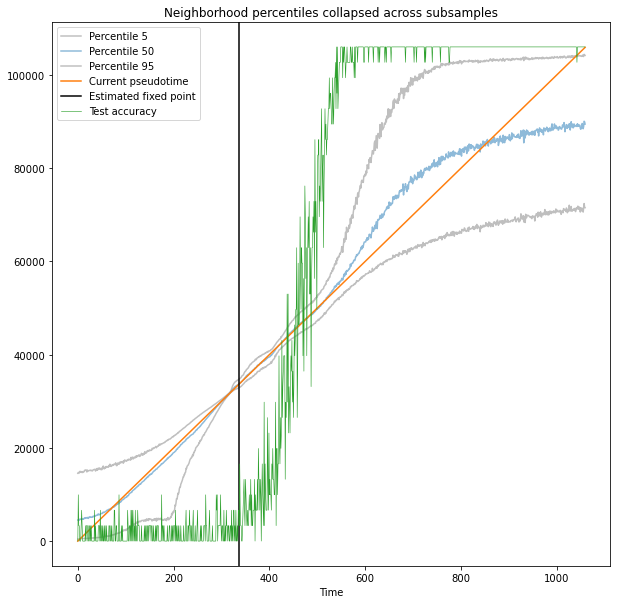

In [3]:
## RUN FOR JUST ONE SPECIFIC SPEC ##
num_subsamples = 100
k = 100
hier_idx = 2
layer = layers[0]
mov_avg = 10 
save_fig = True
collapse_subsamples = True # whether to average across num_subsamples! currently both computed
p_array = [5, 50, 95]

knn_identifier = f'knn_k={k}_subsamples={num_subsamples}'
pkl_name = f'layer={layer}_hier={hier_idx}.pkl'

SAVEDIR = os.path.join(ROOTDIR, 'analyze', knn_identifier, model_identifier, train_identifier)
PLOTDIR = os.path.join(ROOTDIR, 'results', knn_identifier, model_identifier, train_identifier)

if not os.path.exists(PLOTDIR):
    os.makedirs(PLOTDIR)

data = pickle.load(open(os.path.join(SAVEDIR+'/'+pkl_name),'rb'))

D = data['D']
I = data['I']
I_stand = I/np.max(I)
epochs = data['epochs']

D_k_mean = np.mean(D,axis=1)
D_k_mean_collapsed = np.mean(D_k_mean.reshape(-1, num_subsamples),axis=1)

# analyses of fixed points and percentiles
# compute percentiles
p = np.percentile(I, p_array, axis=1)
p_collapse = [np.mean(x.reshape(-1, num_subsamples),axis=1) for x in p]
time_diag = np.arange(len(D_k_mean))
time_diag_collapsed = np.arange(len(D_k_mean_collapsed))*100

norms = np.zeros((k-1, I.shape[0]))
for i in range(1, k):
    norms[i-1, :] = I[:, 0] - I[:, i] 

mean_norms = np.mean(norms,axis=0)
mean_k_norms = np.mean(norms,axis=1)
# norms_mov_avg = (moving_average(abs(mean_norms), mov_avg))

norms_collapsed = np.mean(mean_norms.reshape(-1, num_subsamples),axis=1)

# norms_mov_avg = moving_average(abs(mean_norms), mov_avg)
norms_mov_avg = moving_average(abs(mean_norms), mov_avg)
norms_mov_avg_collapsed = moving_average(abs(norms_collapsed), mov_avg)
fixed_point = np.argmin((norms_mov_avg))
fixed_point_collapsed = np.argmin((norms_mov_avg_collapsed))
print(f'Fixed point collapsed, hierarchy {hier_idx}: {fixed_point_collapsed}')

alpha=0.5
plt.figure(figsize=(10,10))
plt.plot(p_collapse[0], label=f'Percentile {p_array[0]}', alpha=alpha, color='grey')
plt.plot(p_collapse[1], label=f'Percentile {p_array[1]}', alpha=alpha)
plt.plot(p_collapse[2], label=f'Percentile {p_array[2]}', alpha=alpha, color='grey')
plt.xlabel('Time')
plt.title('Neighborhood percentiles collapsed across subsamples')
plt.plot(np.arange(len(p_collapse[0])), time_diag_collapsed, label='Current pseudotime')
plt.axvline(x=fixed_point_collapsed, label='Estimated fixed point', color='black')
plt.plot(np.ravel([np.repeat(x,1) for x in data['test_accs']])*1060, label='Test accuracy', linewidth=0.6)
plt.legend()

In [ ]:
# Investigate why fixed point "goes wrong"

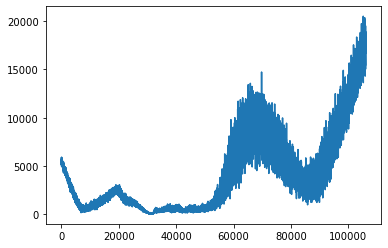

In [6]:
plt.plot(norms_mov_avg)

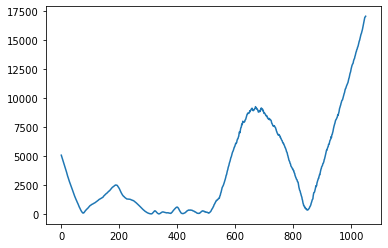

In [7]:
plt.plot(norms_mov_avg_collapsed)

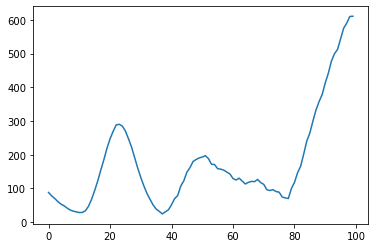

In [9]:
plt.plot(norms_mov_avg_collapsed[300:400])

In [8]:
np.argmin((norms_mov_avg_collapsed))

337

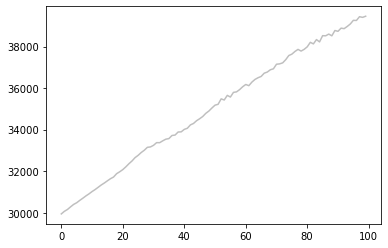

In [11]:
plt.plot(p_collapse[1][300:400], label=f'Percentile {p_array[0]}', alpha=alpha, color='grey')

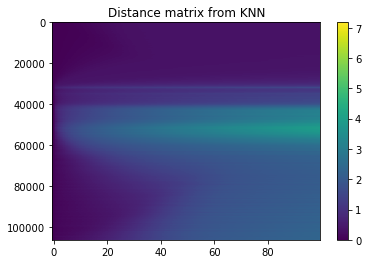

In [12]:
plt.imshow(D,aspect='auto',interpolation=None)
plt.title('Distance matrix from KNN')
plt.colorbar()

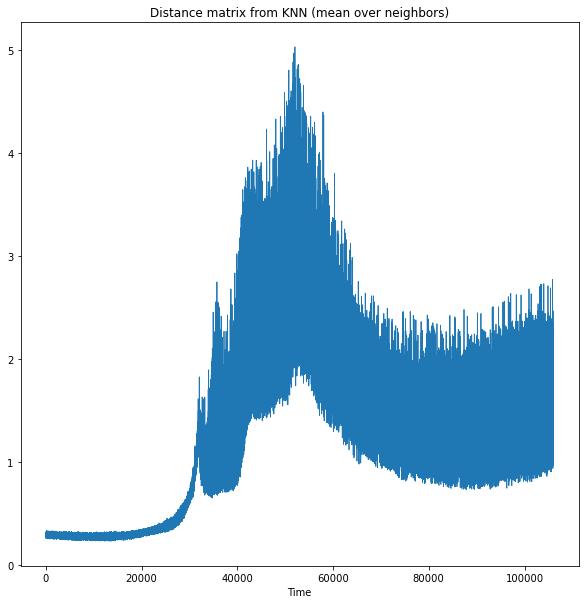

In [13]:
# for exploratory purposes...
plt.figure(figsize=(10,10))
plt.plot(D_k_mean, linewidth=0.8)
plt.title(f'Layer: {layer}; Hierarchy: {hier_idx}: \nDistance matrix from KNN (mean over neighbors)')
plt.xlabel('Time')
# plt.xticks(time_diag[0::100], [str(int(element/100)) for element in time_diag[0::100]])
if save_fig:
    plt.savefig(os.path.join(PLOTDIR, f'dist-matrix_time-avg.pdf'), dpi=240)

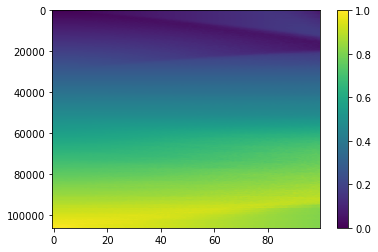

In [32]:
plt.imshow(I_stand,aspect='auto',interpolation=None)
plt.colorbar()

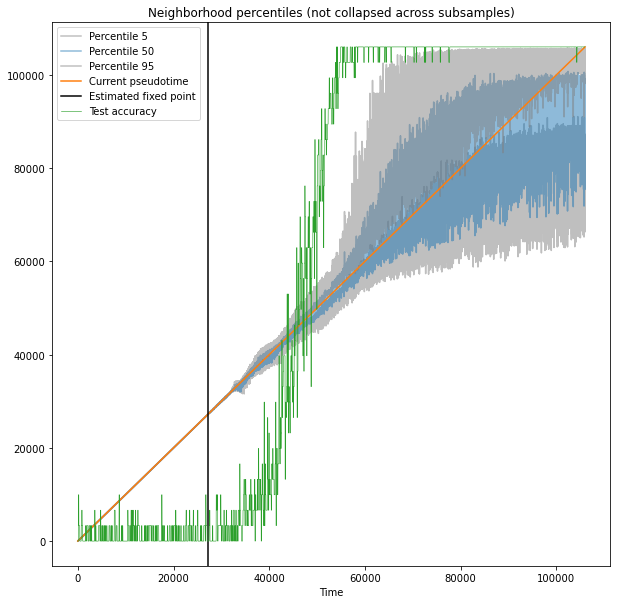

In [18]:
alpha=0.5
plt.figure(figsize=(10,10))
plt.plot(p[0,:], label=f'Percentile {p_array[0]}', alpha=alpha, color='grey')
plt.plot(p[1,:], label=f'Percentile {p_array[1]}', alpha=alpha)
plt.plot(p[2,:], label=f'Percentile {p_array[2]}', alpha=alpha, color='grey')
plt.xlabel('Time')
plt.title('Neighborhood percentiles (not collapsed across subsamples)')
plt.plot(time_diag, label='Current pseudotime')
plt.axvline(x=fixed_point, label='Estimated fixed point', color='black')
plt.plot(np.ravel([np.repeat(x,100) for x in data['test_accs']])*1060, label='Test accuracy', linewidth=0.6)
plt.legend()

Text(0, 0.5, 'Neighborhood distance')

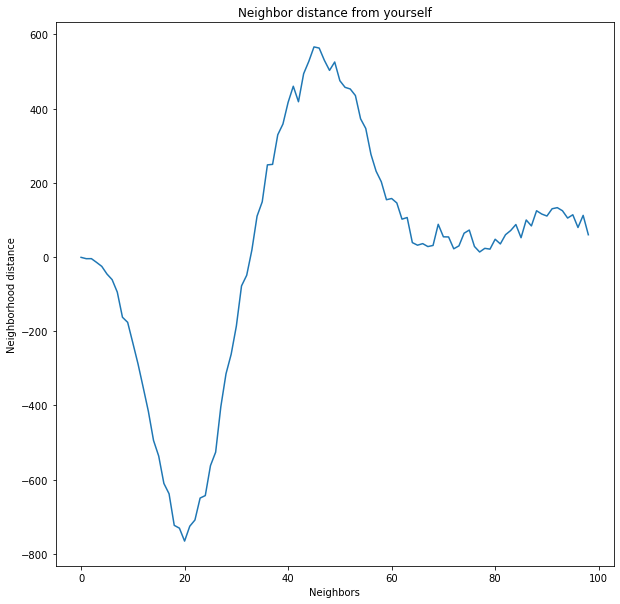